In [1]:
#For calculation
import numpy as np
import geopandas as gpd
import rasterio
from pysheds.grid import Grid
from rasterio.windows import from_bounds
#For plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
#For export
from shapely.geometry import shape

# Provide the local path to the downloaded DEM GeoTIFF file
dem_path = '/opt/homebrew/Cellar/geoserver/2.26.0/libexec/data_dir/data/raster/DTM_5m_eesti.tif'

# User-defined coordinates for catchment delineation
x, y = 659364.7050257636, 6474898.2451943  # Example coordinates (EPSG:3301)

# Define a window around the coordinates (e.g., 5000 meters in each direction)
buffer = 5000  # 5 km buffer
left = x - buffer
right = x + buffer
bottom = y - buffer
top = y + buffer

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
#Plotting functions:

def plotDemData(data, extent):
    fig, ax = plt.subplots(figsize=(8,6))
    #fig.patch.set_alpha(0)

    plt.imshow(data, extent=grid.extent, cmap='terrain', zorder=1)
    plt.colorbar(label='Elevation (m)')
    plt.grid(zorder=0)
    plt.title('Digital elevation map', size=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    

def plotFlow(fdir):
    fig = plt.figure(figsize=(8,6))
    fig.patch.set_alpha(0)

    plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
    boundaries = ([0] + sorted(list(dirmap)))
    plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Flow direction grid', size=14)
    plt.grid(zorder=-1)
    plt.tight_layout()
    

def plotAcc(acc, extent):
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='Upstream Cells')
    plt.title('Flow Accumulation', size=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()


# Plot the catchment with a specified color
def plotCatchment(clipped_catch, extent, color='Greys_r'):
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)

    plt.grid('on', zorder=0)
    im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap=color)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Delineated Catchment', size=14)
    

def plotRiverNetwork():
    sns.set_palette('husl')
    fig, ax = plt.subplots(figsize=(8.5,6.5))

    plt.xlim(grid.bbox[0], grid.bbox[2])
    plt.ylim(grid.bbox[1], grid.bbox[3])
    ax.set_aspect('equal')

    for branch in branches['features']:
        line = np.asarray(branch['geometry']['coordinates'])
        plt.plot(line[:, 0], line[:, 1])
    
    _ = plt.title('D8 channels', size=14)



In [3]:
# Open the DEM using rasterio
with rasterio.open(dem_path) as src:
    # Calculate bounds around the point
    left = x - buffer
    right = x + buffer
    bottom = y - buffer
    top = y + buffer
    
    # Read the window from the DEM around the specified point
    window = from_bounds(left, bottom, right, top, transform=src.transform)
    dem_window = src.read(1, window=window)
    transform = src.window_transform(window)
    profile = src.profile
    profile.update({
        'transform': transform,
        'height': dem_window.shape[0],
        'width': dem_window.shape[1],
        'count': 1
    })

# Create a temporary file to save the DEM window
temp_dem_path = '../data/temp_dem_window.tif'
with rasterio.open(temp_dem_path, 'w', **profile) as dst:
    dst.write(dem_window, 1)

print("DEM window saved to temporary file:", temp_dem_path)
print("DEM window read complete")


DEM window saved to temporary file: ../data/temp_dem_window.tif
DEM window read complete


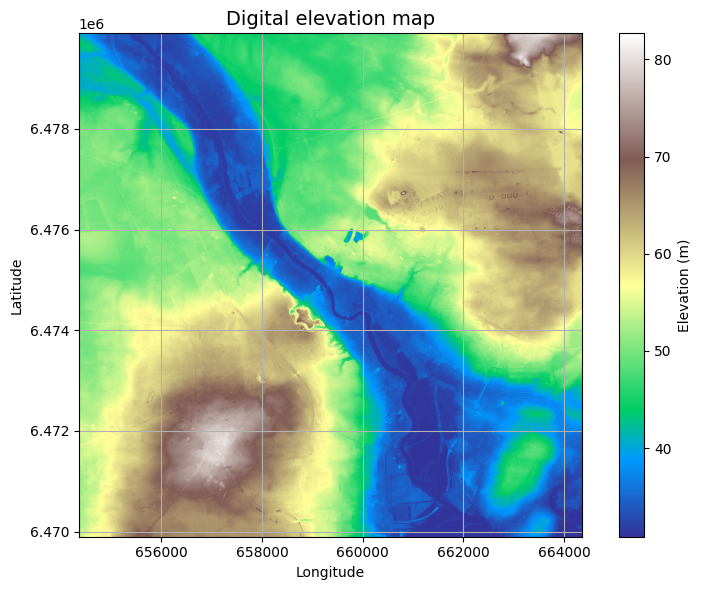

In [4]:
# Initialize Pysheds grid and read the raster data
grid = Grid.from_raster(temp_dem_path, data_name='dem')

# Read the DEM data from the grid as a Raster object
dem_raster = grid.read_raster(temp_dem_path)

plotDemData(dem_raster, grid.extent)

In [5]:
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem_raster)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

print("Filling pits, depressions, and resolving flats complete")

Filling pits, depressions, and resolving flats complete


Flow direction complete


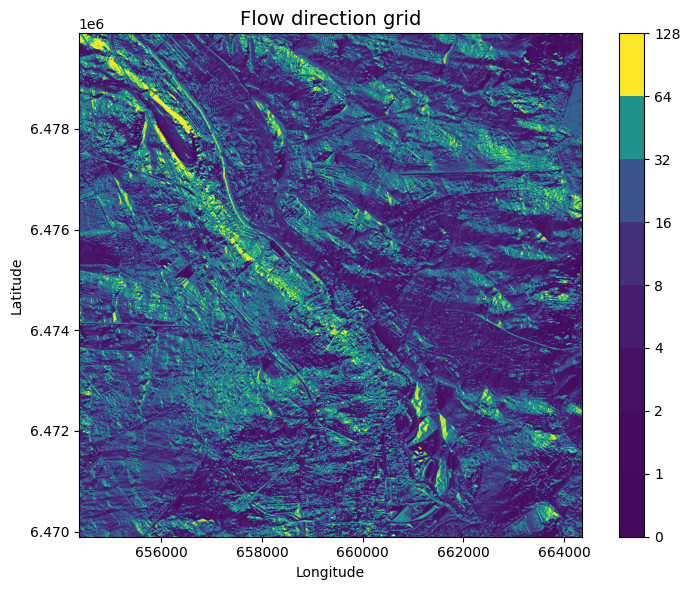

In [6]:
# Direction map for flow directions
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Calculate flow direction using the conditioned DEM
flow_direction = grid.flowdir(inflated_dem, dirmap=dirmap)

print("Flow direction complete")

plotFlow(flow_direction)

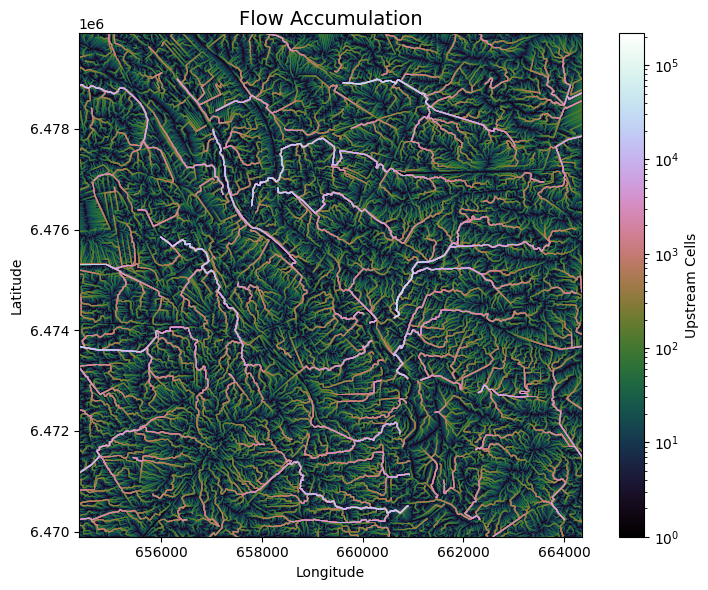

In [7]:
# Calculate flow accumulation
acc = grid.accumulation(flow_direction, dirmap=dirmap)

plotAcc(acc, grid.extent)


Snapped coordinates: 659429.7050257636, 6474878.245194301
Catchment delineation complete


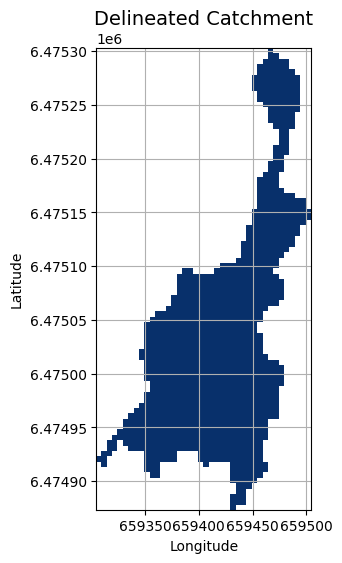

In [8]:
# Snap pour point to high accumulation cell (if necessary)
# The threshold (1000) is used to ensure we snap to a meaningful point in terms of flow accumulation
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

print(f"Snapped coordinates: {x_snap}, {y_snap}")

# Delineate the catchment based on snapped coordinates and flow direction
catch = grid.catchment(x=x_snap, y=y_snap, fdir=flow_direction, dirmap=dirmap, xytype='coordinate')

# Clip the DEM to the catchment area
grid.clip_to(catch)

# View the clipped catchment
clipped_catch = grid.view(catch)

plotCatchment(clipped_catch, grid.extent, color='Blues_r')

print("Catchment delineation complete")



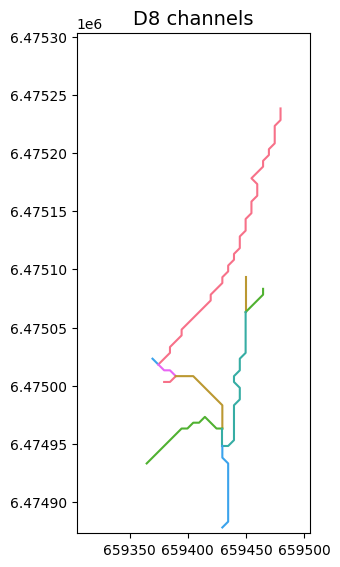

In [9]:
# Extract river network - optional

branches = grid.extract_river_network(flow_direction, acc > 50, dirmap=dirmap)

plotRiverNetwork()

In [10]:
# Convert the catchment into a supported dtype (int32)
catch_int = catch.astype('int32')

# Polygonize the catchment for GeoDataFrame conversion
shapes = grid.polygonize(catch_int)

# Convert the polygonized shapes into GeoJSON-like features
geojson_features = []
for geom, value in shapes:
    if value == 1: # only include areas inside the catchment
        feature = {
            "type": "Feature",
            "geometry": shape(geom).__geo_interface__,
            "properties": {"value": value}
        }
        geojson_features.append(feature)

# Convert to GeoDataFrame for export
gdf_catchment = gpd.GeoDataFrame.from_features(geojson_features, crs='EPSG:3301')

# Save the result as GeoJSON
gdf_catchment.to_file('../output/epsg3301/watershed.geojson', driver='GeoJSON')

print("Watershed delineation saved as GeoJSON")

Watershed delineation saved as GeoJSON


In [11]:
# Convert the river network to a GeoDataFrame for export
gdf_river_network = gpd.GeoDataFrame.from_features(branches, crs='EPSG:3301')

# Save the result as GeoJSON
gdf_river_network.to_file('../output/epsg3301/river_network.geojson', driver='GeoJSON')

print("River network saved as GeoJSON")

River network saved as GeoJSON
